# Sprint 2: Image Restoration Engine

**Project:** Road Defect Detection Pipeline (PROSIT 1)  
**Team:** Naa Lamle Boye, Thomas Kojo Quarshie, Chelsea Owusu, Elijah Boateng  
**Date:** February 2026

## Purpose

The top-down view from Sprint 1 may suffer from motion blur (vehicle vibration) and
shadows (trees, buildings). This notebook restores image quality using:
1. **Wiener Deconvolution** for motion blur removal
2. **Multi-Scale Retinex + CLAHE** for shadow removal

**Input:** `topdown_full.png` from Sprint 1  
**Output:** `restored_topdown.png` for Sprint 3

## Step 1: Import Libraries

In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

print(f"OpenCV: {cv2.__version__}")

OpenCV: 4.13.0


## Step 2: Load Top-Down View from Sprint 1

Loaded: 2090x2120


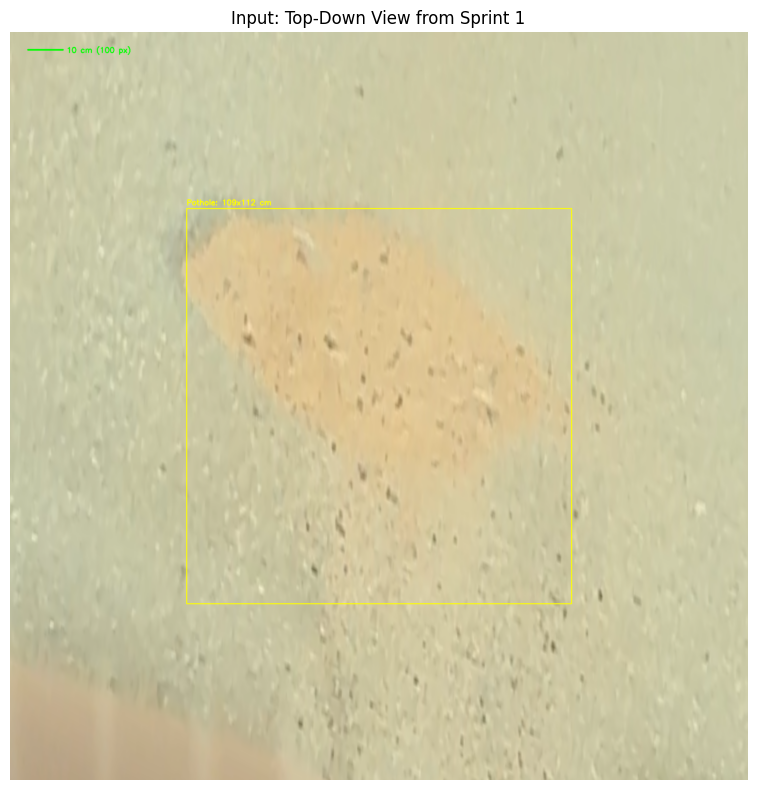

In [2]:
topdown = cv2.imread('topdown_full.png')
if topdown is None:
    raise FileNotFoundError("topdown_full.png not found. Run Sprint 1 first.")
print(f"Loaded: {topdown.shape[1]}x{topdown.shape[0]}")

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cv2.cvtColor(topdown, cv2.COLOR_BGR2RGB))
ax.set_title("Input: Top-Down View from Sprint 1")
ax.axis('off')
plt.tight_layout()
plt.show()

## Step 3: Deblurring (Wiener Deconvolution)

Motion blur from vehicle vibration is modeled as a horizontal blur kernel. The Wiener
filter removes it in the frequency domain.

In [3]:
def deblur_wiener(image, kernel_size=5, snr=100):
    """Remove motion blur using Wiener deconvolution."""
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[kernel_size // 2, :] = 1.0 / kernel_size
    k_fft = np.fft.fft2(kernel, s=image.shape[:2])
    i_fft = np.fft.fft2(image, axes=(0, 1))
    wiener = np.conj(k_fft) / (np.abs(k_fft)**2 + 1.0/snr)
    if len(image.shape) == 3:
        res = np.zeros_like(image, dtype=np.float64)
        for c in range(3):
            res[:,:,c] = np.real(np.fft.ifft2(i_fft[:,:,c] * wiener))
    else:
        res = np.real(np.fft.ifft2(i_fft * wiener))
    return np.clip(res, 0, 255).astype(np.uint8)

deblurred = deblur_wiener(topdown)
cv2.imwrite('test_deblur_output.png', deblurred)
print(f"Deblurred: {deblurred.shape}")

Deblurred: (2120, 2090, 3)


## Step 4: Shadow Removal (Multi-Scale Retinex + CLAHE)

The Retinex algorithm separates reflectance from illumination. CLAHE enhances contrast.

In [4]:
def remove_shadows_retinex(image, sigma_list=[15, 80, 250]):
    """Multi-Scale Retinex shadow removal with CLAHE.
    
    Operates on the L (lightness) channel in LAB space to normalise
    illumination while preserving colour fidelity.
    """
    # Convert to LAB to separate lightness from colour
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_ch, a_ch, b_ch = cv2.split(lab)
    
    # Apply Multi-Scale Retinex to lightness channel only
    l_f = l_ch.astype(np.float64) + 1.0
    log_l = np.log(l_f)
    retinex = np.zeros_like(l_f)
    for sigma in sigma_list:
        blurred = cv2.GaussianBlur(l_f, (0, 0), sigma)
        retinex += (log_l - np.log(blurred + 1.0))
    retinex /= len(sigma_list)
    
    # Normalise using mean/std (robust, avoids outlier-driven min-max)
    mean_r = retinex.mean()
    std_r = retinex.std()
    retinex = (retinex - mean_r) / (std_r * 6.0 + 1e-10) + 0.5
    retinex = np.clip(retinex * 255, 0, 255).astype(np.uint8)
    
    # Apply CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    retinex = clahe.apply(retinex)
    
    # Blend with original L channel to keep natural appearance (70% retinex, 30% original)
    l_out = cv2.addWeighted(retinex, 0.7, l_ch, 0.3, 0)
    
    return cv2.cvtColor(cv2.merge([l_out, a_ch, b_ch]), cv2.COLOR_LAB2BGR)

shadow_removed = remove_shadows_retinex(topdown)
cv2.imwrite('test_shadow_removal_output.png', shadow_removed)
print(f"Shadow removed: {shadow_removed.shape}")
print(f"  Mean pixel value: {shadow_removed.mean():.1f} (original: {topdown.mean():.1f})")

Shadow removed: (2120, 2090, 3)
  Mean pixel value: 134.0 (original: 188.0)


## Step 5: Full Restoration Pipeline

In [5]:
# Full restoration pipeline: deblur first, then shadow removal
restored = deblur_wiener(topdown)
restored = remove_shadows_retinex(restored)
cv2.imwrite('restored_topdown.png', restored)
cv2.imwrite('test_restoration_output.png', restored)
print(f"Restored: {restored.shape}")
print(f"  Mean pixel value: {restored.mean():.1f} (original: {topdown.mean():.1f})")
print("Saved: restored_topdown.png")

Restored: (2120, 2090, 3)
  Mean pixel value: 133.4 (original: 188.0)
Saved: restored_topdown.png


## Step 6: Visual Comparison

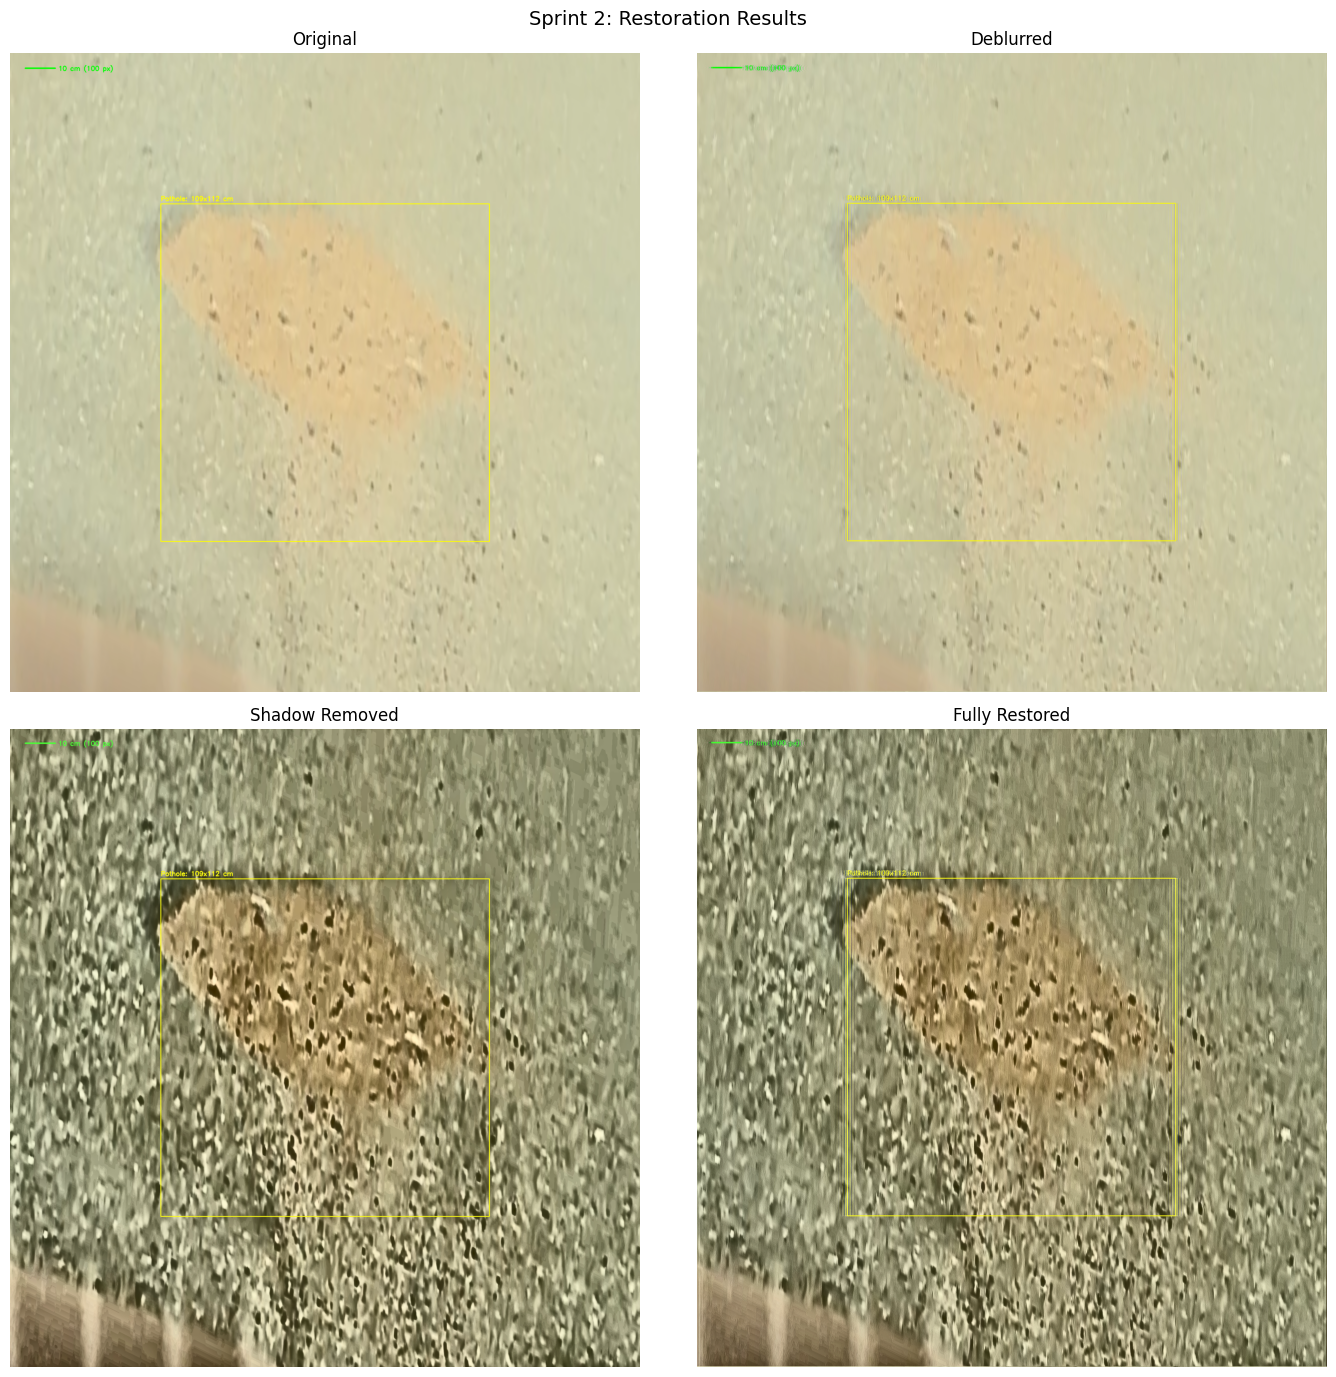

Saved: restoration_comparison.png

Restoration complete. Proceed to Sprint 3.


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
for ax, title, img in zip(axes.flat,
    ['Original', 'Deblurred', 'Shadow Removed', 'Fully Restored'],
    [topdown, deblurred, shadow_removed, restored]):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title, fontsize=12)
    ax.axis('off')
plt.suptitle("Sprint 2: Restoration Results", fontsize=14)
plt.tight_layout()
plt.savefig('restoration_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: restoration_comparison.png")
print("\nRestoration complete. Proceed to Sprint 3.")